# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [28]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig


@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    # sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001
    # sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [29]:
torch.set_grad_enabled(False)

## Load model

In [30]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [31]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [32]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [33]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [34]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [35]:
# all_imagenet_class_names

In [36]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [37]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/layer_9'

## Feature steering

In [47]:
def steering_hook_fn_cls_only(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    # batch, stream, feats
    # cls token is *last* in sequence
    steered_feature_activations[:, 0, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [48]:
random_feat_idxs = np.random.randint(0, high=3000, size=(25))
random_feat_idxs[0] = 655
random_feat_idxs[1] = 656
random_feat_idxs[2] = 665

In [60]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
#     _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
#         print(f"Feature: {idx} ====================")
        
        # steering_hook_fn, steering_hook_fn_cls_only
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
#     print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

#     print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
#     print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [61]:
import torch
from PIL import Image

from collections import defaultdict
max_samples = cfg.eval_max

encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

steering_strengths = [0.0, 5.0, 10.0, 20.0, 50.0, 150.0, 300.0, 500.0]#, -200.0, -300.0]


steering_strength_image_results = defaultdict(dict)
steering_strength_info = {}

og_model.cuda()




for steering_strength in steering_strengths:
    print(f"{'==============' * 2} steering_strength: {steering_strength} {'==============' * 2}")
    # ===== Get Steered and Default CLIP Outputs =====
    top_k=10
    processed_samples = 0
    default_embeds_list = []
    feature_steered_embeds = defaultdict(list)
    l = 0
    
    # remove tqdm
    for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
        batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            None, None, top_k, steering_strength
        )
        default_embeds_list.append(default_embeds)
        for j, altered_embeds in enumerate(altered_embeds_list):
            feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
        # either label embeds or optimize to maximal token in text transformer embedding face
        l += 1
        if l >= 1:
            break    
    default_embeds = torch.cat(default_embeds_list)
    
    with open("/workspace/clip_dissect_raw.txt", "r") as f:
        larger_vocab = [line[:-1] for line in f.readlines()][:5000]


    # ===== CLIP Embeds =====
    # use clip vocab here and compare embeds
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(larger_vocab)
    text_features = og_model.encode_text(text.cuda())
    text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


    print(f"text_features_normed.shape: {text_features_normed.shape}")
    text_probs_altered_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for key in feature_steered_embeds:
            print(key)
            # embeds already have L2 norm of 1
            text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
            text_probs_altered_list.append(text_probs_altered)
        text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

#     print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
#     print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]
    
    
    # ===== Logit Difference =====
    # indexed as such in steering_strength_image_results:
    # per steering strength
    # per feature
    # per image
    
    selected_vocab = larger_vocab

    top_concept_per_feat = {}
    top_val_per_feat = {}
    top_diff_per_feat = {}
    top_ratio_per_feat = {}
    
    # run this for sampled features over all of imagenet eval
    for j, text_probs_altered in enumerate(text_probs_altered_list):
        print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
#         print("actual image content:")
        default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
#         print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])


        logit_diff = text_probs_altered - text_probs_default
        logit_diff_aggregate = logit_diff.sum(dim=0)

        logit_ratio = text_probs_altered/text_probs_default
        logit_ratio_aggregate = logit_ratio.mean(dim=0)

        print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
        text_probs_altered_softmax = text_probs_altered.softmax(1)
        vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)

    #     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
    #     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
    #     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)

#         print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
#         print(np.array(selected_vocab)[idxs_softmax.cpu()])
#         for i in range(vals_softmax.shape[0]):
#             print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
#             break

    #     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
    #     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])

        vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
        vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)

        ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
        ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)

        vals, idxs = torch.topk(logit_diff,k=5)
        vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)

        ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
        ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)

        # random_feat_idxs[j] is the index of the feature
        for img_idx in range(batch_images.shape[0]):
            if random_feat_idxs[j] not in steering_strength_image_results[str(steering_strength)].keys():
                steering_strength_image_results[str(steering_strength)][random_feat_idxs[j].copy()] = []
            # entries are torch.topk(k=10) results
            steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]].append((np.array(selected_vocab, copy=True)[idxs_softmax.cpu()][img_idx], torch.clone(vals_softmax[img_idx])))
        
        # per image
        top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
        top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
        
        # aggregate
        top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
        top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]


        print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
        print(np.array(selected_vocab)[idxs_agg.cpu()])
#         print(vals_least_agg)
#         print(np.array(selected_vocab)[idxs_least_agg.cpu()])

        print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
        print(ratios_agg)
        print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
#         print(ratios_least_agg)
#         print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])
    
    steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


============================ steering_strength: 0.0 ============================


  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0018, 0.0013, 0.0013, 0.0009, 0.0009, 0.0006, 0.0004, 0.0003, 0.0003,
        0.0003], device='cuda:0')
['hairy' 'dog' 'model' 'golden' 'roof' 'museum' 'cafe' 'milfhunter' 'cock'
 'douglas']

Most Changed, by Ratio Over 32 Images:
tensor([1.0043, 1.0043, 1.0037, 1.0036, 1.0031, 1.0031, 1.0031, 1.0029, 1.0028,
        1.0028], device='cuda:0')
['wings' 'tokyo' 'plastic' 'coast' 'jul' 'japan' 'stereo' 'coastal'
 'costa' 'ear']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0049, 0.0042, 0.0027, 0.0022, 0.0019, 0.0014, 0.0012, 0.0012, 0.0010,
        0.0009], device='cuda:0')
['ski' 'adopted' 'model' 'mouse' 'boxes' 'kits' 


Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0027, 0.0026, 0.0015, 0.0014, 0.0009, 0.0008, 0.0005, 0.0005, 0.0004,
        0.0004], device='cuda:0')
['dolls' 'eating' 'boxes' 'hairy' 'package' 'stars' 'ski' 'guinea' 'dogs'
 'rolling']

Most Changed, by Ratio Over 32 Images:
tensor([1.0044, 1.0040, 1.0038, 1.0037, 1.0036, 1.0035, 1.0033, 1.0032, 1.0032,
        1.0030], device='cuda:0')
['spain' 'split' 'miles' 'leave' 'nice' 'particular' 'sleep' 'jerry'
 'rolling' 'catch']

For Feature 2596
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0007, 0.0006, 0.0005, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003,
        0.0002], device='cuda:0')
['adopted' 'pair' 'douglas' 'foster' 'turkey' 'eagle' 'depth' 'python'
 'rolling' 'model']

Most Changed, by Ratio Over 32 Images:
tensor([1.0029, 1.0029, 1.0024, 1.0024, 1.0024, 1.0023, 1.0022, 1.0022, 1.0022,
        1.0022], device='cuda:0')
['portugal' 'shadow' 'jonathan'

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.2691, 0.2021, 0.2020, 0.1952, 0.1753, 0.1413, 0.1369, 0.1295, 0.1212,
        0.0912], device='cuda:0')
['dolls' 'eagle' 'fucking' 'hunting' 'mouse' 'roads' 'conservation'
 'guinea' 'roof' 'links']

Most Changed, by Ratio Over 32 Images:
tensor([9.9347, 9.2574, 8.6827, 8.3259, 7.4986, 7.3675, 7.3523, 7.1602, 6.6852,
        6.5630], device='cuda:0')
['rss' 'wholesale' 'xxx' 'bags' 'ministry' 'agreements' 'bonds' 'links'
 'attendance' 'availability']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.3895, 0.2026, 0.1828, 0.1748, 0.1731, 0.1517, 0.1481, 0.1441, 0.1365,
        0.1248], device='cuda:0')
['dog' 'purple' 'apple'


Most Changed, by Absolute Diff Over 32 Images:
tensor([0.4181, 0.3259, 0.2451, 0.2149, 0.1770, 0.1574, 0.1276, 0.1165, 0.1159,
        0.1074], device='cuda:0')
['python' 'dog' 'mouse' 'bears' 'vehicle' 'structural' 'model' 'mit'
 'hairy' 'cute']

Most Changed, by Ratio Over 32 Images:
tensor([7.4852, 7.2984, 6.1887, 6.0589, 5.6836, 5.6055, 5.4979, 5.3556, 5.3333,
        5.2677], device='cuda:0')
['alaska' 'html' 'cotton' 'xml' 'patent' 'seattle' 'tissue' 'clothing'
 'phentermine' 'denver']

For Feature 2773
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.2387, 0.2290, 0.2239, 0.1970, 0.1831, 0.1487, 0.1243, 0.1206, 0.1066,
        0.0936], device='cuda:0')
['flying' 'dolls' 'museum' 'vehicle' 'turkey' 'mit' 'ski' 'tea' 'visitor'
 'roof']

Most Changed, by Ratio Over 32 Images:
tensor([10.0580,  8.8930,  6.8734,  6.0344,  6.0008,  5.9331,  5.7751,  5.7110,
         5.6935,  5.6759], device='cuda:0')
['hospital' 'meter' 'h

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.7553, 0.4588, 0.3161, 0.2988, 0.2679, 0.2637, 0.2534, 0.1784, 0.1771,
        0.1624], device='cuda:0')
['conservation' 'dolls' 'eagle' 'felt' 'purple' 'hunting' 'links' 'bowl'
 'bears' 'fucking']

Most Changed, by Ratio Over 32 Images:
tensor([151.7220, 125.4206, 107.7547,  85.9695,  78.0027,  75.9435,  68.4573,
         65.8482,  62.8024,  59.7922], device='cuda:0')
['bags' 'rss' 'xxx' 'wholesale' 'laptops' 'bonds' 'agreements'
 'contractors' 'brands' 'offers']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.9691, 0.4783, 0.3911, 0.3085, 0.2248, 0.2230, 0.2130, 0.2035, 0.2005,
        0.1889], device='cuda:0')
['dog' 'p


Most Changed, by Absolute Diff Over 32 Images:
tensor([0.6548, 0.5923, 0.4358, 0.3934, 0.2915, 0.2727, 0.1935, 0.1919, 0.1708,
        0.1595], device='cuda:0')
['dog' 'python' 'cute' 'bears' 'vehicle' 'mouse' 'structural' 'flying'
 'hairy' 'adult']

Most Changed, by Ratio Over 32 Images:
tensor([136.7664,  78.1775,  60.5248,  56.7834,  56.5326,  56.3114,  54.2098,
         51.1474,  41.7656,  41.5724], device='cuda:0')
['alaska' 'seattle' 'html' 'patent' 'clothing' 'airlines' 'denver'
 'cotton' 'phentermine' 'pubmed']

For Feature 2773
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.5993, 0.2938, 0.2887, 0.2729, 0.2686, 0.2359, 0.2243, 0.1984, 0.1952,
        0.1723], device='cuda:0')
['flying' 'vehicle' 'dolls' 'museum' 'python' 'dog' 'roof' 'tea' 'visitor'
 'wildlife']

Most Changed, by Ratio Over 32 Images:
tensor([74.7531, 71.1079, 70.1079, 66.1550, 63.3704, 62.3255, 62.1338, 60.3701,
        59.5846, 59.2894], device

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.5076, 0.9779, 0.5841, 0.5067, 0.4517, 0.3758, 0.3481, 0.3283, 0.2997,
        0.2826], device='cuda:0')
['conservation' 'felt' 'dogs' 'dolls' 'pottery' 'links' 'verzeichnis'
 'binding' 'firefox' 'bears']

Most Changed, by Ratio Over 32 Images:
tensor([8509.5391, 4772.6172, 3600.7678, 2715.4761, 2267.6716, 2256.8306,
        2235.0500, 2172.0049, 2153.6301, 2094.9995], device='cuda:0')
['bags' 'brands' 'presentations' 'laptops' 'tables' 'certificates'
 'crafts' 'rss' 'awards' 'wholesale']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.0258, 0.8363, 0.5677, 0.2891, 0.2792, 0.2618, 0.2541, 0.2090, 0.2064,
        0.2005], d


Most Changed, by Absolute Diff Over 32 Images:
tensor([0.9763, 0.6088, 0.2848, 0.2263, 0.2138, 0.2015, 0.1844, 0.1661, 0.1582,
        0.1567], device='cuda:0')
['conservation' 'flying' 'swimming' 'watching' 'engineering' 'hunting'
 'beastiality' 'wildlife' 'toys' 'dog']

Most Changed, by Ratio Over 32 Images:
tensor([4859.1230, 3583.4949, 2882.4614, 2396.8228, 2069.8782, 2007.4663,
        2003.7068, 1751.6561, 1725.7968, 1673.4369], device='cuda:0')
['buildings' 'websites' 'building' 'contractors' 'engineering' 'lake'
 'engineers' 'apartments' 'swimming' 'street']

For Feature 478
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.0106, 0.7168, 0.5997, 0.3248, 0.3113, 0.3013, 0.2695, 0.2691, 0.2582,
        0.2143], device='cuda:0')
['dog' 'balls' 'toys' 'pet' 'wing' 'wings' 'provisions' 'furniture'
 'spyware' 'produce']

Most Changed, by Ratio Over 32 Images:
tensor([19419.4688,  6255.9995,  6133.5576,  5812.5352,  5631.94

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.6291, 0.9716, 0.9184, 0.7120, 0.6663, 0.4315, 0.4019, 0.3364, 0.3245,
        0.2726], device='cuda:0')
['for' 'posts' 'outdoor' 'pair' 'thumbnail' 'felt' 'sterling' 'wholesale'
 'peer' 'estate']

Most Changed, by Ratio Over 32 Images:
tensor([232949.5000, 143069.0000,  92122.9609,  79913.3203,  73186.1641,
         61242.3047,  54763.0352,  43138.8672,  41579.6992,  41040.0742],
       device='cuda:0')
['laptops' 'bags' 'tables' 'presentations' 'betting' 'crafts' 'guestbook'
 'networking' 'brands' 'navy']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.5435, 1.1550, 0.9887, 0.6765, 0.4595, 0.4058, 0.2974, 0.2590, 0.2359,


Most Changed, by Absolute Diff Over 32 Images:
tensor([1.5502, 0.8010, 0.7714, 0.7273, 0.7144, 0.6868, 0.6010, 0.5283, 0.5244,
        0.4646], device='cuda:0')
['guides' 'pair' 'bands' 'merchandise' 'couples' 'pets' 'pin' 'clubs'
 'soldiers' 'communities']

Most Changed, by Ratio Over 32 Images:
tensor([692649.1875, 401294.1250, 235295.6406, 188779.6562, 177818.5625,
        149555.5469, 136416.1875, 133785.0625, 130162.4375,  90693.6875],
       device='cuda:0')
['bands' 'owners' 'sponsors' 'officers' 'bears' 'farmers' 'soldiers'
 'stars' 'picks' 'pets']

For Feature 2596
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.2001, 0.6489, 0.6452, 0.3947, 0.3819, 0.3427, 0.2515, 0.2151, 0.1935,
        0.1599], device='cuda:0')
['weight' 'merchandise' 'it' 'ram' 'scale' 'seller' 'potter' 'fl' 'et'
 'news']

Most Changed, by Ratio Over 32 Images:
tensor([360553.0312, 137996.4844,  84549.7500,  40671.8594,  38461.2109,
         3

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([2.0951, 1.5323, 1.1852, 0.7186, 0.7115, 0.6643, 0.5152, 0.4448, 0.3628,
        0.3546], device='cuda:0')
['for' 'pair' 'listening' 'posts' 'lot' 'estate' 'post' 'sterling'
 'containing' 'pm']

Most Changed, by Ratio Over 32 Images:
tensor([708388.1250, 298176.4062, 211621.7656, 175056.9062, 160939.3125,
        116493.7031, 101212.9453,  68757.0469,  59526.9531,  56710.6094],
       device='cuda:0')
['laptops' 'laptop' 'betting' 'pink' 'jewellery' 'tables' 'desk' 'bags'
 'networking' 'presentations']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([2.8821, 1.7943, 1.0880, 1.0285, 0.9586, 0.6880, 0.6621, 0.5363, 0.4479,
      


Most Changed, by Absolute Diff Over 32 Images:
tensor([2.8153, 1.0229, 0.6880, 0.6366, 0.6223, 0.5717, 0.5666, 0.5610, 0.4663,
        0.4198], device='cuda:0')
['pets' 'merchandise' 'guides' 'bears' 'printable' 'dogs' 'sharing'
 'stars' 'pair' 'couples']

Most Changed, by Ratio Over 32 Images:
tensor([1787876.3750, 1507432.3750, 1111928.6250,  846088.5625,  650194.3750,
         645600.5000,  542144.5625,  391790.7812,  325345.0938,  280676.6562],
       device='cuda:0')
['stars' 'pets' 'shops' 'bears' 'appliances' 'dogs' 'customers' 'farmers'
 'quotes' 'bands']

For Feature 2596
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.0961, 0.5916, 0.5895, 0.5039, 0.4513, 0.4108, 0.4013, 0.3758, 0.3604,
        0.3516], device='cuda:0')
['alan' 'it' 'dell' 'jack' 'instance' 'font' 'ram' 'michigan'
 'merchandise' 'www']

Most Changed, by Ratio Over 32 Images:
tensor([782781.7500, 430332.5000, 109605.1875, 105754.5859,  99094.0078,

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([2.2346, 1.7028, 1.6495, 0.7784, 0.6857, 0.5166, 0.4697, 0.4448, 0.4188,
        0.3939], device='cuda:0')
['listening' 'for' 'pair' 'lot' 'estate' 'posts' 'post' 'costa'
 'containing' 'latest']

Most Changed, by Ratio Over 32 Images:
tensor([799613.5625, 490967.9688, 332448.9062, 245971.9688, 239566.9844,
        128398.0781,  99453.7969,  80871.0781,  71839.8438,  65321.6367],
       device='cuda:0')
['laptops' 'laptop' 'pink' 'betting' 'jewellery' 'desk' 'tables' 'purple'
 'tampa' 'catalog']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([3.2305, 1.7426, 1.5990, 1.1492, 1.0546, 0.5275, 0.4954, 0.4929, 0.4115,
        0.3780


Most Changed, by Absolute Diff Over 32 Images:
tensor([3.5226, 0.9601, 0.8943, 0.7979, 0.7819, 0.7741, 0.6199, 0.4566, 0.4158,
        0.3951], device='cuda:0')
['pets' 'dogs' 'printable' 'stars' 'merchandise' 'bears' 'sharing'
 'friends' 'guides' 'pair']

Most Changed, by Ratio Over 32 Images:
tensor([2672093.5000, 2212523.0000, 1442687.6250, 1213010.0000, 1146000.3750,
        1098850.0000,  739847.0625,  641485.8750,  284076.7188,  280519.4062],
       device='cuda:0')
['stars' 'pets' 'shops' 'appliances' 'dogs' 'bears' 'customers' 'quotes'
 'bedrooms' 'farmers']

For Feature 2596
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.5276, 0.7405, 0.7388, 0.6434, 0.5398, 0.4872, 0.4613, 0.4204, 0.4198,
        0.4171], device='cuda:0')
['alan' 'after' 'dell' 'jack' 'ink' 'michigan' 'instance' 'front' 'it'
 'allen']

Most Changed, by Ratio Over 32 Images:
tensor([1136974.1250,  291464.0938,  195251.8281,  179108.9062,  165756.

  0%|                                                                                                            | 0/1562 [00:02<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
204
1692
371
1595
2598
546
20
606
2536
393
2726
2596
113
2773
478
138
854
2594
1839
1325
2741
1405

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([2.8452, 1.6594, 1.5318, 0.7851, 0.6719, 0.4717, 0.4417, 0.4362, 0.4314,
        0.4276], device='cuda:0')
['listening' 'pair' 'for' 'lot' 'estate' 'costa' 'laptop' 'posts'
 'containing' 'post']

Most Changed, by Ratio Over 32 Images:
tensor([821473.8750, 570925.7500, 419022.0000, 283203.1562, 258654.3750,
        136030.2812, 105980.2578,  91627.6094,  83168.8125,  77567.2109],
       device='cuda:0')
['laptops' 'laptop' 'pink' 'jewellery' 'betting' 'desk' 'purple' 'tables'
 'tampa' 'catalog']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([3.0230, 1.7687, 1.6539, 1.1005, 1.0040, 0.5000, 0.4982, 0.4947, 0.4487,
        0.4379


Most Changed, by Absolute Diff Over 32 Images:
tensor([3.7628, 1.1587, 0.9932, 0.8779, 0.8405, 0.7014, 0.6252, 0.4783, 0.3491,
        0.3294], device='cuda:0')
['pets' 'dogs' 'printable' 'stars' 'bears' 'merchandise' 'sharing'
 'friends' 'pair' 'guides']

Most Changed, by Ratio Over 32 Images:
tensor([2978085.0000, 2485363.7500, 1512741.1250, 1511416.3750, 1404908.5000,
        1210662.0000,  836621.1875,  827574.9375,  320507.0312,  286712.7812],
       device='cuda:0')
['stars' 'pets' 'shops' 'appliances' 'dogs' 'bears' 'quotes' 'customers'
 'bedrooms' 'cats']

For Feature 2596
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([1.6464, 0.9712, 0.7784, 0.6897, 0.6781, 0.5210, 0.5115, 0.4340, 0.4253,
        0.4057], device='cuda:0')
['alan' 'after' 'dell' 'jack' 'ink' 'michigan' 'front' 'instance' 'allen'
 'www']

Most Changed, by Ratio Over 32 Images:
tensor([1309097.6250,  248114.0469,  239742.2656,  238925.4844,  194389.59

In [62]:
steering_strength_image_results.keys(), steering_strength_image_results[str(steering_strength)].keys()

(dict_keys(['0.0', '5.0', '10.0', '20.0', '50.0', '150.0', '300.0', '500.0']),
 dict_keys([655, 656, 665, 204, 1692, 371, 1595, 2598, 546, 20, 606, 2536, 393, 2726, 2596, 113, 2773, 478, 138, 854, 2594, 1839, 1325, 2741, 1405]))

In [63]:
i = 0
# 0: python, 3: bowl, 4: bed, 6: guinea
image_idx = 4
feat_num = 665

# to iterate over many features:
# for feat_num in steering_strength_image_results[str(steering_strength)].keys():

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_prob_arr = []
for dict_key in steering_strengths:
    # image, tuple position, idx of top-k
    # modify this to do top-k at some point
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0])
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item())
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))


feat_num: 665
0.0 bed
0.0 0.00027093198150396347
5.0 dolls
5.0 0.00026961290859617293
10.0 dolls
10.0 0.0002578500716481358
20.0 cute
20.0 0.00025297317188233137
50.0 cute
50.0 0.00021267806005198509
150.0 anime
150.0 0.00022063031792640686
300.0 anime
300.0 0.00021524658950511366
500.0 anime
500.0 0.00021318456856533885


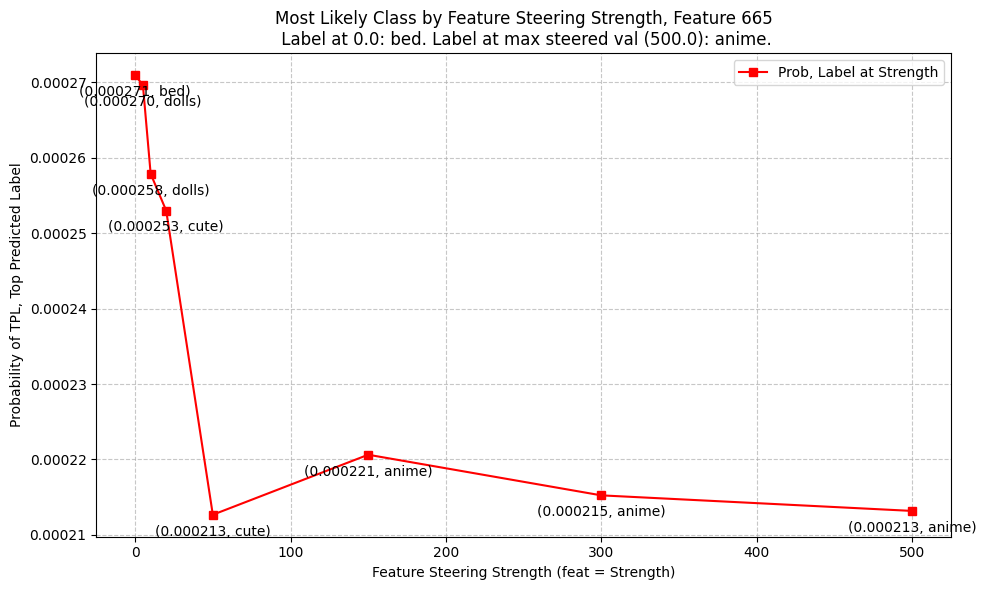

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

In [65]:
# i = 0
# for feat_num in steering_strength_info[steering_strength][0].keys():
#     print(f"=====================\nfeat_num: {feat_num}")
#     feat_num_concept_arr = []
#     feat_num_prob_arr = []
#     feat_num_ratio_arr = []
#     for key in steering_strength_info:
#         print(key, steering_strength_info[key][0][feat_num])
#         feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
#         print(key, steering_strength_info[key][1][feat_num])
#         feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
#         print(key, steering_strength_info[key][2][feat_num])
#         feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
#     i += 1
#     if i > 7:
#         break

### Prev Code

In [ ]:
len(feature_steered_embeds[random_feat_idxs[0]])

In [ ]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

In [ ]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

In [ ]:
og_model.cuda()

In [ ]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [ ]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

### Summed Logit Difference

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])

In [ ]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

In [ ]:
steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [ ]:
steering_strength_info[steering_strength][0].keys()

In [ ]:
steering_strength_info

In [ ]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

In [ ]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [ ]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [ ]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [ ]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [ ]:
dists_from_feat_0.norm(p=2, dim=0).shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape